# Блок с импортом библиотек

In [ ]:
!pip install pytorch-transformers
!pip install evaluate
!pip install huggingface_hub transformers

In [ ]:
import pandas as pd
import numpy as np
import torch
import os
from pytorch_transformers import BertTokenizer, BertConfig
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from pytorch_transformers import BertTokenizer, BertConfig
from pytorch_transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm
import io
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import evaluate
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    TrainerCallback
)
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
lemmatizer = WordNetLemmatizer()
stop_words_en = set(stopwords.words('english'))
stemmer_en = SnowballStemmer('english')
from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print("CUDA is available?", torch.cuda.is_available())


CUDA is available? True


# Данные

In [ ]:
file_path = "/content/drive/MyDrive/IMDB Dataset.csv"
data = pd.read_csv(file_path)
data['sentiment'] = data['sentiment'].map({'negative': 0, 'positive': 1})
# data = data.head(10000)
data

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0


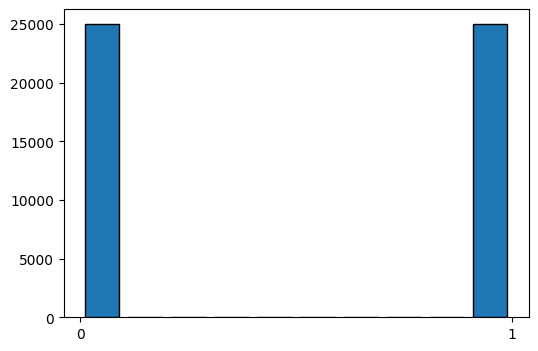

In [ ]:
plt.figure(figsize=(6, 4))
plt.hist(data['sentiment'], edgecolor='black', rwidth=0.8)
plt.xticks([0, 1])
plt.show()

In [ ]:
train_df, val_df = train_test_split(data, test_size=0.3, random_state=42)

In [ ]:
class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in encoding.items()}
        item["labels"] = torch.tensor(label, dtype=torch.long)
        return item

In [ ]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
train_dataset = IMDBDataset(
    texts=train_df["review"],
    labels=train_df["sentiment"],
    tokenizer=tokenizer
)

val_dataset = IMDBDataset(
    texts=val_df["review"],
    labels=val_df["sentiment"],
    tokenizer=tokenizer
)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
model

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_metric.compute(predictions=preds, references=labels)
    f1 = f1_metric.compute(predictions=preds, references=labels, average="weighted")
    return {"accuracy": acc["accuracy"], "f1": f1["f1"]}

In [ ]:
class PlotCallback(TrainerCallback):
    def __init__(self):
        super().__init__()
        self.train_loss_values = []
        self.eval_loss_values = []
        self.eval_acc_values = []
        self.epochs = []

    def on_epoch_end(self, args, state, control, **kwargs):
        metrics = kwargs.get("metrics", {})
        epoch = int(state.epoch) if state.epoch is not None else len(self.epochs)+1

        self.train_loss_values.append(metrics.get("train_loss", None))
        self.eval_loss_values.append(metrics.get("eval_loss", None))
        self.eval_acc_values.append(metrics.get("eval_accuracy", None))
        self.epochs.append(epoch)

        clear_output(wait=True)
        plt.figure(figsize=(8,5))

        plt.plot(self.epochs, self.train_loss_values, label="Train Loss")
        plt.plot(self.epochs, self.eval_loss_values, label="Eval Loss")

        ax = plt.gca()
        ax2 = ax.twinx()
        ax2.plot(self.epochs, self.eval_acc_values, label="Eval Accuracy", color="green")
        ax2.set_ylabel("Accuracy")

        plt.title("Loss & Accuracy by Epoch")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.legend(loc="upper left")
        plt.show()

In [ ]:
training_args = TrainingArguments(
    output_dir="./tmp",
    save_strategy="no",
    evaluation_strategy="epoch",
    logging_steps=100,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    learning_rate=5e-5,
    optim="adamw_torch",
    lr_scheduler_type="linear",
    warmup_steps=1546,
    # max_steps=15468,
    num_train_epochs=3,
    seed=42,
    report_to="none",
    no_cuda=False
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[PlotCallback()],
)

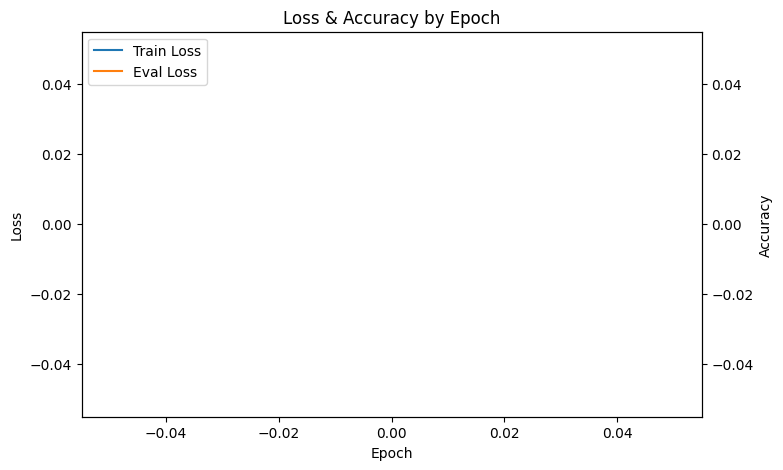

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.276300,0.290672,0.925467,0.925469
2,0.202000,0.250537,0.938467,0.938467
3,0.069000,0.321992,0.941200,0.941192


Final Evaluation: {'eval_loss': 0.32199159264564514, 'eval_accuracy': 0.9412, 'eval_f1': 0.9411919250004326, 'eval_runtime': 434.7776, 'eval_samples_per_second': 34.5, 'eval_steps_per_second': 2.157, 'epoch': 3.0}


In [ ]:
trainer.train()

eval_result = trainer.evaluate()
print("Final Evaluation:", eval_result)

In [ ]:
model.save_pretrained("/content/drive/MyDrive/all_optimiz_bert_imdb_dir")
tokenizer.save_pretrained("/content/drive/MyDrive/all_optimiz_bert_imdb_dir")

('/content/drive/MyDrive/all_optimiz_bert_imdb_dir/tokenizer_config.json',
 '/content/drive/MyDrive/all_optimiz_bert_imdb_dir/special_tokens_map.json',
 '/content/drive/MyDrive/all_optimiz_bert_imdb_dir/vocab.txt',
 '/content/drive/MyDrive/all_optimiz_bert_imdb_dir/added_tokens.json',
 '/content/drive/MyDrive/all_optimiz_bert_imdb_dir/tokenizer.json')